將影片丟到 examples/video 裡面，更改影片名稱後按全部執行就會輸出角度和線性的影片，在examples資料夾中的"影片名稱_output" 資料夾中

In [26]:
import subprocess
import os

input_video_name = "福田3.mp4" # 修改影片名稱

input_video_path = f"C:/Users/user/Desktop/AlphaPose/examples/video/{input_video_name}"
input_video_name = input_video_name.split(".")[0]
output_video_path = f"C:/Users/user/Desktop/AlphaPose/examples/{input_video_name}_output"

if not os.path.exists(output_video_path):
    os.makedirs(output_video_path, exist_ok=True)

env_name = "alphapose"
command_str = (
    f"cd C:/Users/user/Desktop/AlphaPose"
    f" && conda activate {env_name}"
    f" && python C:/Users/user/Desktop/AlphaPose/scripts/demo_inference.py"
    f" --cfg C:/Users/user/Desktop/AlphaPose/configs/halpe_26/resnet/256x192_res50_lr1e-3_1x.yaml"
    f" --checkpoint C:/Users/user/Desktop/AlphaPose/pretrained_models/halpe26_fast_res50_256x192.pth"
    f" --video {input_video_path}"
    f" --save_video"
    f" --outdir {output_video_path}"
    f" --flip"
    f" --detector yolo"
    f" --min_box_area 154700"
)

subprocess.run(command_str, shell=True, check=True)

CompletedProcess(args='cd C:/Users/user/Desktop/AlphaPose && conda activate alphapose && python C:/Users/user/Desktop/AlphaPose/scripts/demo_inference.py --cfg C:/Users/user/Desktop/AlphaPose/configs/halpe_26/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint C:/Users/user/Desktop/AlphaPose/pretrained_models/halpe26_fast_res50_256x192.pth --video C:/Users/user/Desktop/AlphaPose/examples/video/福田3.mp4 --save_video --outdir C:/Users/user/Desktop/AlphaPose/examples/福田3_output --flip --detector yolo --min_box_area 154700', returncode=0)

In [27]:
import json
import csv
import os
import numpy as np

NUM_KEYPOINTS = 26  # Halpe 26
KPT = {
    "Nose" : 0,
    "Left_Eye" : 1,
    "Right_Eye" : 2,
    "Left_Ear" : 3,
    "Right_Ear" : 4,
    "Left_Shoulder" : 5,
    "Right_Shoulder" : 6,
    "Left_Elbow" : 7,
    "Right_Elbow" : 8,
    "Left_Wrist" : 9,
    "Right_Wrist" : 10,
    "Left_Hip" : 11,
    "Right_Hip" : 12,
    "Left_Knee" : 13,
    "Right_Knee" : 14,
    "Left_Ankle" : 15,
    "Right_Ankle" : 16,
    "Head" : 17,
    "Neck" : 18,
    "Hip" : 19,
    "Left_BigToe" : 20,
    "Right_BigToe" : 21,
    "Left_SmallToe" : 22,
    "Right_SmallToe" : 23,
    "Left_Heel" : 24,
    "Right_Heel" : 25
}

def get_joints_xy(keypoints, part_idx):
    i = part_idx * 3
    return keypoints[i], keypoints[i+1]

def calculate_angle(a, b, c):
    """
    計算以 b 為頂點、由 a 與 c 所構成的角度 (單位：度)。
    a, b, c 均為 (x, y)。
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ab = a - b
    cb = c - b

    norm_ab = np.linalg.norm(ab)
    norm_cb = np.linalg.norm(cb)

    # 若向量長度為 0，避免除以 0
    if norm_ab == 0 or norm_cb == 0:
        return 0.0

    cosine_angle = np.dot(ab, cb) / (norm_ab * norm_cb)
    # clip 避免浮點誤差導致超出 [-1, 1]
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# 指定 JSON 結果資料夾和輸出 CSV 檔案
output_csv = "ankle_coordinates.csv"  # 儲存結果的 CSV 檔名

header = ['Frame']
for joints in KPT.keys():
    header.append(f'{joints}_X')
    header.append(f'{joints}_Y')

# 初始化 CSV
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # CSV 欄位
    writer.writerow(header)

    for file_name in os.listdir(output_video_path):
        if not file_name.endswith(".json"):
            continue
        
        json_path = os.path.join(output_video_path, file_name)
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for record in data:
            image_id = record.get("image_id", "Unknown")
            keypoints = record.get("keypoints", [])
            frame_name = image_id.split('.')[0]

            if len(keypoints) == len(KPT) * 3:

                # 依序讀取所有關節的 (x, y)
                row = [frame_name]  # 第 0 欄是 Frame
                for kpt_name, kpt_index in KPT.items():
                    x, y = get_joints_xy(keypoints, kpt_index)
                    row.append(x)
                    row.append(y)

                writer.writerow(row)

print(f"處理完成！輸出結果已儲存至 {output_csv}")

處理完成！輸出結果已儲存至 ankle_coordinates.csv


# 取得關節X、Y座標

In [28]:
import csv
import math
import os
import numpy as np

###############################
# 1. 配置區：關節名稱與角度設定 #
###############################

# 定義要計算的角度，key 為「結果欄位名稱」，value 為 (A, B, C) 三個關節名稱
# B 為角度頂點，角度 = ∠ABC
ANGLES_TO_COMPUTE = {
    "Left_Elbow_Angle": ("Left_Shoulder", "Left_Elbow", "Left_Wrist"),
    "Right_Elbow_Angle": ("Right_Shoulder", "Right_Elbow", "Right_Wrist"),
    "Left_Shoulder_Angle": ("Left_Hip", "Left_Shoulder", "Left_Elbow"),
    "Right_Shoulder_Angle": ("Right_Hip", "Right_Shoulder", "Right_Elbow"),
    "Left_Hip_Angle": ("Left_Shoulder", "Left_Hip", "Left_Knee"),
    "Right_Hip_Angle": ("Right_Shoulder", "Right_Hip", "Right_Knee"),
    "Left_Knee_Angle": ("Left_Hip", "Left_Knee", "Left_Ankle"),
    "Right_Knee_Angle": ("Right_Hip", "Right_Knee", "Right_Ankle"),
    "Left_Ankle_Angle": ("Left_Knee", "Left_Ankle", "Left_SmallToe"),
    "Right_Ankle_Angle": ("Right_Knee", "Right_Ankle", "Right_SmallToe")
}

###############################
# 2. 工具函式：取得 (x,y) 與角度 #
###############################

def get_xy_from_row(row, header_map, joint_name):
    """
    根據關節名稱 joint_name，從 row 取出 (x, y)。
    header_map 是欄位名稱 -> 欄位索引的映射。
    row 是一行資料(list)，內含所有欄位值。
    """
    x_col = header_map[f"{joint_name}_X"]
    y_col = header_map[f"{joint_name}_Y"]
    x_val = float(row[x_col])
    y_val = float(row[y_col])
    return (x_val, y_val)

def compute_angle(a, b, c):
    """
    計算向量 AB 與 CB 的夾角 (度數)。
    a, b, c 均為 (x, y) 二維座標，b 為角度頂點。
    ∠ABC = arccos( (AB · CB) / (|AB| * |CB|) )
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ab = a - b
    cb = c - b

    norm_ab = np.linalg.norm(ab)
    norm_cb = np.linalg.norm(cb)
    
    if norm_ab == 0 or norm_cb == 0:
        # 避免除以 0
        return 0.0

    cos_theta = np.dot(ab, cb) / (norm_ab * norm_cb)
    # clip 避免浮點誤差 >1 或 < -1
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle = math.degrees(math.acos(cos_theta))
    return angle

##################
# 3. 主程式流程  #
##################

# 舊的 CSV (含所有關節座標)
input_csv = "ankle_coordinates.csv"
# 新的 CSV (只要角度)
output_csv = "joints_angle.csv"

# 讀取舊 CSV
with open(input_csv, 'r', encoding='utf-8') as fin:
    reader = csv.reader(fin)
    headers = next(reader)  # 取出標題列

    # 建立欄位名稱 -> 索引的映射，方便之後直接用字串取得 col index
    header_map = {h: i for i, h in enumerate(headers)}

    # 準備新 CSV 的標題: Frame + 要計算的角度欄位們
    # 例如: ["Frame", "LeftKneeAngle", "RightKneeAngle", ...]
    out_headers = ["Frame"] + list(ANGLES_TO_COMPUTE.keys())

    with open(output_csv, 'w', newline='', encoding='utf-8') as fout:
        writer = csv.writer(fout)
        writer.writerow(out_headers)

        # 逐行讀取舊 CSV 的資料
        for row in reader:
            # 取得 Frame 名稱
            frame_name = row[header_map["Frame"]]

            # 計算所有定義好的角度
            angle_values = []
            for angle_name, (A, B, C) in ANGLES_TO_COMPUTE.items():
                # 取出三個關節的 (x,y)
                a_xy = get_xy_from_row(row, header_map, A)
                b_xy = get_xy_from_row(row, header_map, B)
                c_xy = get_xy_from_row(row, header_map, C)

                angle_deg = compute_angle(a_xy, b_xy, c_xy)
                angle_values.append(f"{angle_deg:.2f}")  # 保留小數點 2 位

            # 寫入新的一行: [frame_name] + 各角度值
            writer.writerow([frame_name] + angle_values)

print(f"Done! New CSV saved as: {output_csv}")

Done! New CSV saved as: joints_angle.csv


# 繪製角度

In [29]:
import csv
import cv2
import os

def main():
    # === 1. 讀取角度 CSV ===
    angles_csv = "joints_angle.csv"   # 這裡放你已計算好角度的 CSV 路徑
    for file_name in os.listdir(output_video_path):
        if not file_name.endswith(".mp4"):
            continue

        video_path = os.path.join(output_video_path, file_name)

    output_path = f"{output_video_path}/pose_with_angles.mp4"  # 輸出帶角度的影片

    # angles_dict 用於儲存 {frame_index: {angle_name: angle_value, ...}, ...}
    angles_dict = {}
    angle_headers = []  # 紀錄有哪些「角度欄位」(不包含第一欄 Frame)

    with open(angles_csv, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader)   # 第一列: Frame, LeftKneeAngle, RightKneeAngle, ...
        # 假設 headers[0] = "Frame"
        angle_headers = headers[1:]  # 剩餘的欄位都是角度欄位

        for row in reader:
            # 讀取 frame
            frame_str = row[0]
            try:
                frame_idx = int(frame_str)
            except ValueError:
                continue

            # 讀取該幀各角度
            angle_values_dict = {}
            for angle_name, angle_val_str in zip(angle_headers, row[1:]):
                try:
                    angle_val = float(angle_val_str)
                except ValueError:
                    angle_val = 0.0
                angle_values_dict[angle_name] = angle_val

            angles_dict[frame_idx] = angle_values_dict

    # === 2. 開啟影片，用 OpenCV 逐幀讀取並疊加角度文字 ===
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"無法開啟影片: {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # 設定 VideoWriter，編碼可依需求調整（例如 "XVID", "avc1", "mp4v"）
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_index = 0  # 記錄當前處理到第幾幀 (0-based)

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 影片已讀取完畢

        # === 3. 從 angles_dict 中取出該幀所有角度，並畫在畫面上 ===
        if frame_index in angles_dict:
            angle_values_dict = angles_dict[frame_index]
            # 以一個簡單的方式把所有角度都畫上去
            base_x, base_y = 50, 50    # 文字起始位置
            delta_y = 30               # 每多一個角度，文字向下偏移多少

            for i, angle_name in enumerate(angle_headers):
                if angle_name in angle_values_dict:
                    angle_val = angle_values_dict[angle_name]
                    text = f"{angle_name}: {angle_val:.2f}"
                    # 在畫面上疊加文字
                    # 參數：影像、文字、左下角座標、字型、字體大小、顏色(BGR)、粗細
                    if angle_name == "Left_Hip_Angle":
                        cv2.putText(frame, text,
                                (width-500, 50),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Right_Hip_Angle":
                        cv2.putText(frame, text,
                                (width-500, 80),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Left_Knee_Angle":
                        cv2.putText(frame, text,
                                (width-500, 110),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Right_Knee_Angle":
                        cv2.putText(frame, text,
                                (width-500, 140),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Left_Ankle_Angle":
                        cv2.putText(frame, text,
                                (width-500, 170),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Right_Ankle_Angle":
                        cv2.putText(frame, text,
                                (width-500, 200),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    # 上半身
                    elif angle_name == "Left_Elbow_Angle":
                        cv2.putText(frame, text,
                                (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Right_Elbow_Angle":
                        cv2.putText(frame, text,
                                (50, 80),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Left_Shoulder_Angle":
                        cv2.putText(frame, text,
                                (50, 110),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)
                    elif angle_name == "Right_Shoulder_Angle":
                        cv2.putText(frame, text,
                                (50, 140),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.0, (0, 0, 255), 2, cv2.LINE_AA)


        # === 4. 將處理後的畫面寫入輸出影片 ===
        out.write(frame)

        frame_index += 1

    # === 5. 結束並釋放資源 ===
    cap.release()
    out.release()
    print(f"處理完成，輸出影片: {output_path}")

if __name__ == "__main__":
    main()

處理完成，輸出影片: C:/Users/user/Desktop/AlphaPose/examples/福田3_output/pose_with_angles.mp4


## Savitzky-Golay 濾波器

有效波峰已保存至 'valid_peaks.csv'


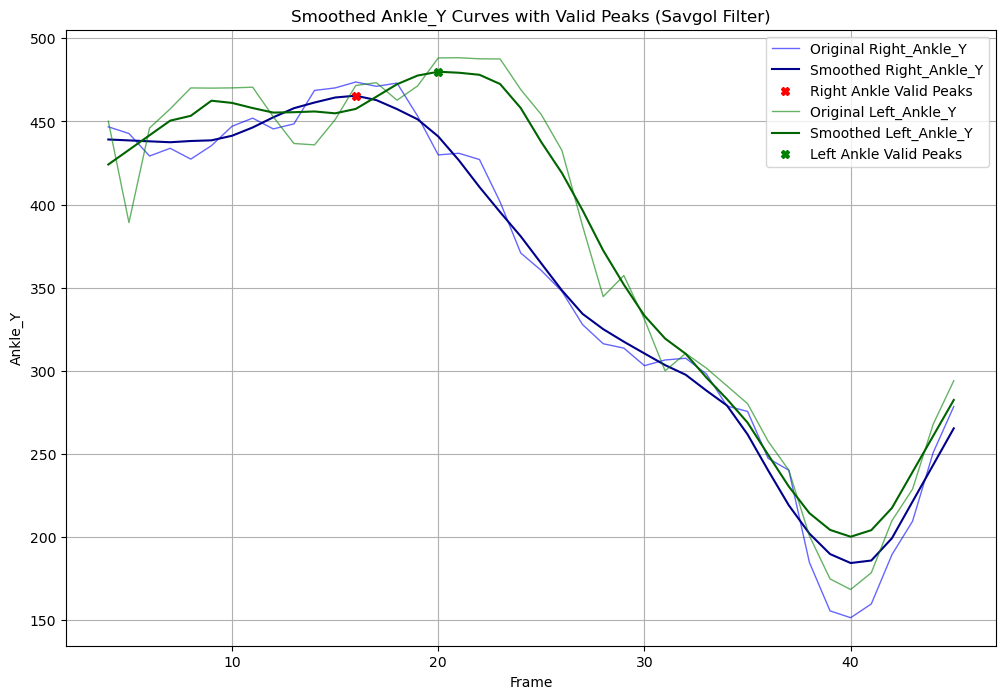

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences, savgol_filter

# 讀取 CSV 文件
file_path = 'ankle_coordinates.csv'
data = pd.read_csv(file_path)

# 提取所需欄位
frames = data['Frame']
right_y_values = data['Right_SmallToe_Y']
right_x_values = data['Right_SmallToe_X']
left_y_values = data['Left_SmallToe_Y']
left_x_values = data['Left_SmallToe_X']

# 使用 Savitzky-Golay 濾波器平滑數據
window_length = 7  # 濾波窗口大小，必須為奇數(11)
polyorder = 1       # 多項式階數(3)

smoothed_right_y_values = savgol_filter(right_y_values, window_length, polyorder)
smoothed_left_y_values = savgol_filter(left_y_values, window_length, polyorder)

# 檢測右腳波峰
right_peaks, _ = find_peaks(smoothed_right_y_values)
right_prominences = peak_prominences(smoothed_right_y_values, right_peaks)[0]
right_valid_peaks = right_peaks[right_prominences > 20]  # 顯著性閾值可調整

# 檢測左腳波峰
left_peaks, _ = find_peaks(smoothed_left_y_values)
left_prominences = peak_prominences(smoothed_left_y_values, left_peaks)[0]
left_valid_peaks = left_peaks[left_prominences > 20]

# 提取右腳有效波峰的幀數、X、Y 座標
right_peak_data = pd.DataFrame({
    'Frame_Right': frames.iloc[right_valid_peaks].values,
    'X_Right': right_x_values.iloc[right_valid_peaks].values,
    'Y_Right': smoothed_right_y_values[right_valid_peaks]
})

# 提取左腳有效波峰的幀數、X、Y 座標
left_peak_data = pd.DataFrame({
    'Frame_Left': frames.iloc[left_valid_peaks].values,
    'X_Left': left_x_values.iloc[left_valid_peaks].values,
    'Y_Left': smoothed_left_y_values[left_valid_peaks]
})

# 合併左右腳波峰數據，按需要保存
peak_data = pd.concat([right_peak_data, left_peak_data], axis=1)
peak_data.to_csv('valid_peaks.csv', index=False)

print("有效波峰已保存至 'valid_peaks.csv'")

# 繪製曲線並標記有效波峰
plt.figure(figsize=(12, 8))

# 右腳曲線與波峰
plt.plot(frames, right_y_values, label='Original Right_Ankle_Y', linewidth=1, alpha=0.6, color='blue')
plt.plot(frames, smoothed_right_y_values, label='Smoothed Right_Ankle_Y', linewidth=1.5, color='darkblue')
plt.plot(right_peak_data['Frame_Right'], right_peak_data['Y_Right'], 'rX', label='Right Ankle Valid Peaks')  # 右腳波峰

# 左腳曲線與波峰
plt.plot(frames, left_y_values, label='Original Left_Ankle_Y', linewidth=1, alpha=0.6, color='green')
plt.plot(frames, smoothed_left_y_values, label='Smoothed Left_Ankle_Y', linewidth=1.5, color='darkgreen')
plt.plot(left_peak_data['Frame_Left'], left_peak_data['Y_Left'], 'gX', label='Left Ankle Valid Peaks')  # 左腳波峰

# 美化圖表
plt.title('Smoothed Ankle_Y Curves with Valid Peaks (Savgol Filter)')
plt.xlabel('Frame')
plt.ylabel('Ankle_Y')
plt.legend()
plt.grid(True)
plt.show()

## 時間

In [6]:
import cv2
import pandas as pd
import numpy as np
import os

# 讀取波峰資訊
csv_file = 'valid_peaks.csv'
peak_data = pd.read_csv(csv_file)

# 合併左右腳的標記，並按幀數排序
all_peaks = []
if 'Frame_Right' in peak_data and 'X_Right' in peak_data:
    all_peaks.extend([(row['Frame_Right'], row['X_Right'], 'Right') for _, row in peak_data.iterrows() if not pd.isna(row['Frame_Right'])])
if 'Frame_Left' in peak_data and 'X_Left' in peak_data:
    all_peaks.extend([(row['Frame_Left'], row['X_Left'], 'Left') for _, row in peak_data.iterrows() if not pd.isna(row['Frame_Left'])])
all_peaks.sort(key=lambda x: x[0])  # 按幀數排序

# print(all_peaks)

# 影片路徑
# input_video = 'examples/res/AlphaPose_Eric.mp4'

files_starting_with_A = [
    os.path.join(output_video_path, f)
    for f in os.listdir(output_video_path)
    if os.path.isfile(os.path.join(output_video_path, f)) and f.startswith('A')
]
for video_path in files_starting_with_A:
    print(video_path)

output_video = f'{output_video_path}/pose_with_intervals.mp4'

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print('Error: Unable to open video file.')
    exit()

# 影片屬性
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 初始化影片寫入器
out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# 創建持久化畫布
persistent_canvas = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

# 初始化變數
last_peak_frame = None

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 檢查當前幀是否有標記
    for peak_frame, x, label in all_peaks:

        if frame_count == peak_frame:
            x = int(x)
            # 繪製垂直線
            color = (0, 0, 255) if label == 'Right' else (0, 255, 0)  # 右腳紅色，左腳綠色
            cv2.line(persistent_canvas, (x, 0), (x, frame_height), color, 2)

            # 計算並顯示時間間隔
            if last_peak_frame is not None:
                interval = (frame_count - last_peak_frame) / fps  # 計算時間間隔
                text = f'{interval:.2f}s'
                cv2.putText(persistent_canvas, text, (x + 10, round(frame_height // 2 * 1.4)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)  # 黃色文字顯示間隔
            last_peak_frame = frame_count

    # 疊加畫布到當前幀
    overlay_frame = cv2.addWeighted(frame, 1.0, persistent_canvas, 0.7, 0)

    # 寫入處理後的幀
    out.write(overlay_frame)
    frame_count += 1

cap.release()
out.release()
print(f"Processed video saved as: {output_video}")

C:/Users/nfu/Desktop/AlphaPose/examples/hj_output\AlphaPose_hj.mp4
Processed video saved as: C:/Users/nfu/Desktop/AlphaPose/examples/hj_output/pose_with_intervals.mp4
